In [1]:
import pandas as pd 
import os
import matplotlib.pyplot as plt
import json
import mne
import numpy as np
from tqdm import tqdm
import re
from sklearn.preprocessing import StandardScaler
from multiprocessing import Pool
import warnings
import math

os.chdir('../..')

# Load the PSDs
Normalization is not needed for this method!

In [2]:
loaded = np.load('./Generated/Spectrums/psds_array_fft.npz')

results_arr = []

i = 0
while f'psd_{i}' in loaded:
    psd = loaded[f'psd_{i}']
    s_id = int(loaded[f'subject_id_{i}'])
    t_id = int(loaded[f'trial_id_{i}'])
    gender = str(loaded[f'gender_{i}'])
    handiness = str(loaded[f'handiness_{i}'])
    age = int(loaded[f'age_{i}'])
    
    results_arr.append([psd, s_id, t_id, gender, handiness, age])
    i += 1

psd, s_id, t_id, gender, handiness, age = results_arr[10]
psd.shape

(63, 381)

### Normalize

In [3]:
# import numpy as np

# # Предполагаем, что results_arr — это список кортежей (psd, s_id, t_id, ...)
# # Собираем все PSD в массив (n_subjects, 63, 381)
# all_psds = np.array([psd for psd, *_ in results_arr])  # shape: (N, 63, 381)

# # Нормализация по испытуемым (ось 0)
# mean_across_subjects = np.mean(all_psds, axis=0)  # (63, 381)
# std_across_subjects = np.std(all_psds, axis=0)    # (63, 381)

# # Добавим защиту от деления на 0
# std_across_subjects[std_across_subjects == 0] = 1e-12

# # z-score нормализация
# norm_psds = (all_psds - mean_across_subjects) / std_across_subjects  # (N, 63, 381)

# # 
# results_arr = [
#     (norm_psds[i], s_id, t_id, gender, handiness, age)
#     for i, (_, s_id, t_id, gender, handiness, age) in enumerate(results_arr)
# ]

# Calcilate log spectral difference (in db)

13


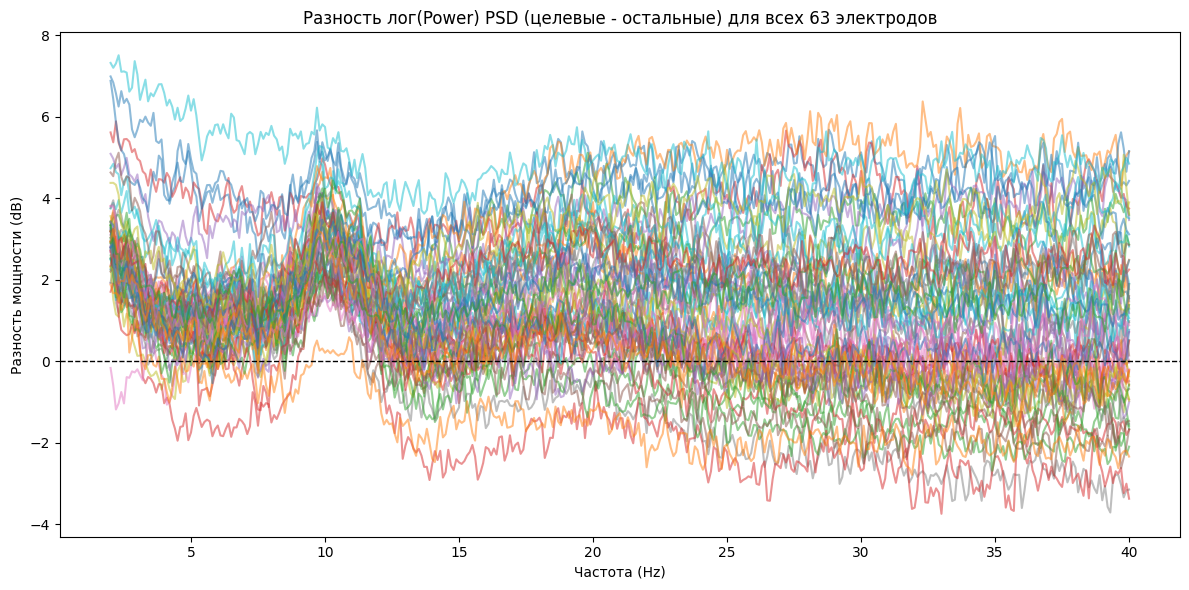

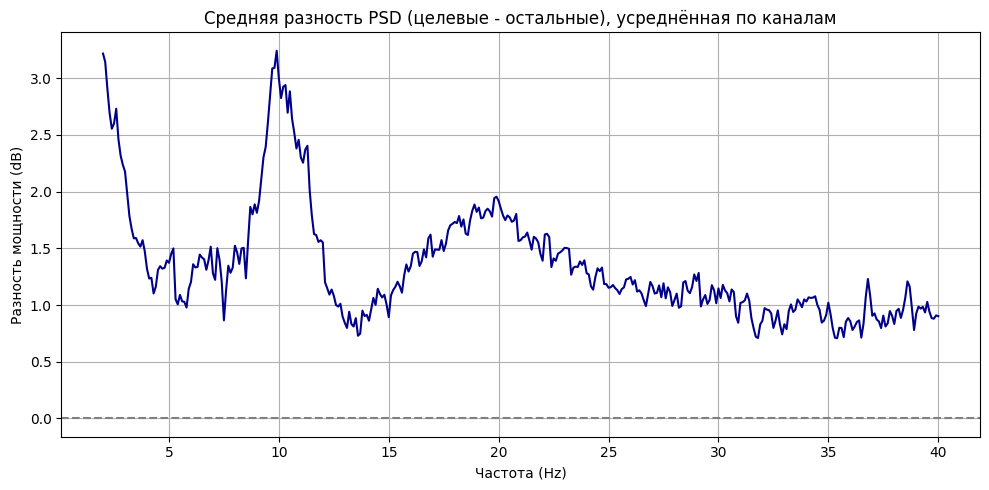

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Umap 2 clusters
# target_list = ['S11_T2', 'S4_T2', 'S8_T1', 'S15_T2', 'S15_T1', 'S4_T1', 'S3_T2',
#                'S10_T2', 'S1_T2', 'S8_T2', 'S6_T2', 'S1_T1', 'S6_T1']

# rest_list = ['S14_T1', 'S5_T2', 'S5_T1', 'S3_T1', 'S2_T2', 'S2_T1', 'S7_T2',
#              'S7_T1', 'S10_T1', 'S12_T2', 'S12_T1', 'S16_T2', 'S16_T1',
#              'S11_T1', 'S9_T2', 'S9_T1', 'S13_T2', 'S13_T1']

# Umap 1st cluster split by 2
target_list = ['S15_T1', 'S4_T1', 'S3_T2',
               'S10_T2', 'S1_T2', 'S8_T2', 'S6_T2', 'S1_T1', 'S6_T1']

rest_list = ['S11_T2', 'S4_T2', 'S8_T1', 'S15_T2']

# Umap 2nd cluster split by 2
# target_list = ['S7_T2', 'S7_T1', 'S9_T2', 'S9_T1', 'S14_T1']

# rest_list = ['S5_T2', 'S5_T1', 'S3_T1', 'S2_T2', 'S2_T1',
#                'S10_T1', 'S12_T2', 'S12_T1', 'S16_T2', 'S16_T1',
#                'S11_T1', 'S13_T2', 'S13_T1']

# Разделим на целевые и остальные
target_psds = []
rest_psds = []

print(len(target_list) + len(rest_list))

for psd, s_id, t_id, *_ in results_arr:
    key = f"S{s_id}_T{t_id}"
    if key in target_list:
        target_psds.append(psd)
    elif key in rest_list:
        rest_psds.append(psd)

# В массивы
target_psds = np.array(target_psds)  # (n_target, 63, 381)
rest_psds = np.array(rest_psds)      # (n_rest, 63, 381)

# Логарифмирование перед усреднением (в dB)
target_psds_db = 10 * np.log10(target_psds + 1e-12)
rest_psds_db   = 10 * np.log10(rest_psds + 1e-12)

# Среднее по группам
target_mean_psd = target_psds_db.mean(axis=0)
rest_mean_psd   = rest_psds_db.mean(axis=0)

# Разность
diff_psd = target_mean_psd - rest_mean_psd  # (63, 381)

# Частотная ось
freqs = np.linspace(2, 40, diff_psd.shape[1])

# Визуализация
plt.figure(figsize=(12, 6))
for i in range(63):
    plt.plot(freqs, diff_psd[i], alpha=0.5, label=f"Ch {i+1}")

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel("Частота (Hz)")
plt.ylabel("Разность мощности (dB)")
plt.title("Разность лог(Power) PSD (целевые - остальные) для всех 63 электродов")
plt.tight_layout()
plt.show()





# В массивы
target_psds = np.array(target_psds)  # (n_target, 63, 381)
rest_psds = np.array(rest_psds)      # (n_rest, 63, 381)

target_psds = 10 * np.log10(target_psds + 1e-12)
rest_psds   = 10 * np.log10(rest_psds + 1e-12)

# Среднее по выборке (по людям)
target_mean = target_psds.mean(axis=0)  # (63, 381)
rest_mean = rest_psds.mean(axis=0)      # (63, 381)

# Разность
diff = target_mean - rest_mean  # (63, 381)

# Среднее по каналам → одна кривая
mean_diff = diff.mean(axis=0)  # (381,)

# Частотная ось
freqs = np.linspace(2, 40, mean_diff.shape[0])

# Визуализация
plt.figure(figsize=(10, 5))
plt.plot(freqs, mean_diff, color='darkblue')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Средняя разность PSD (целевые - остальные), усреднённая по каналам")
plt.xlabel("Частота (Hz)")
plt.ylabel("Разность мощности (dB)")
plt.grid(True)
plt.tight_layout()
plt.show()

4 records.


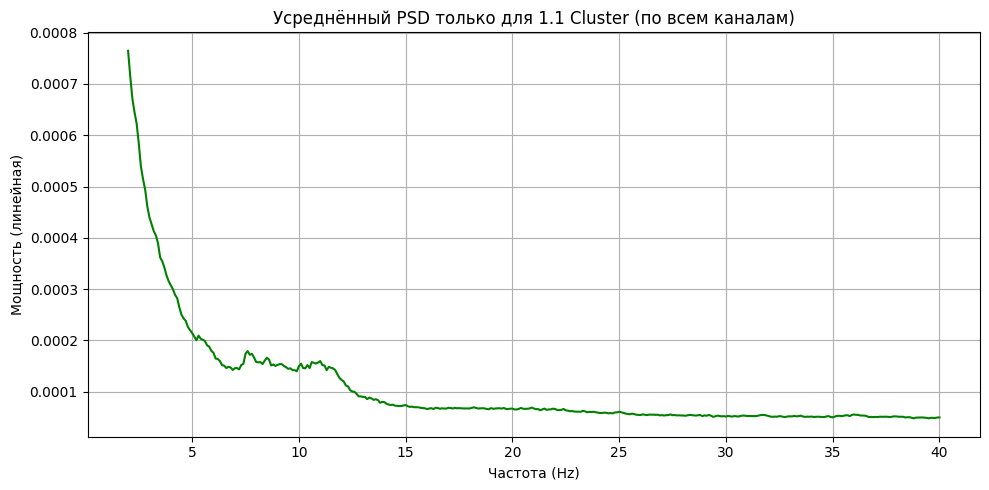

9 records.


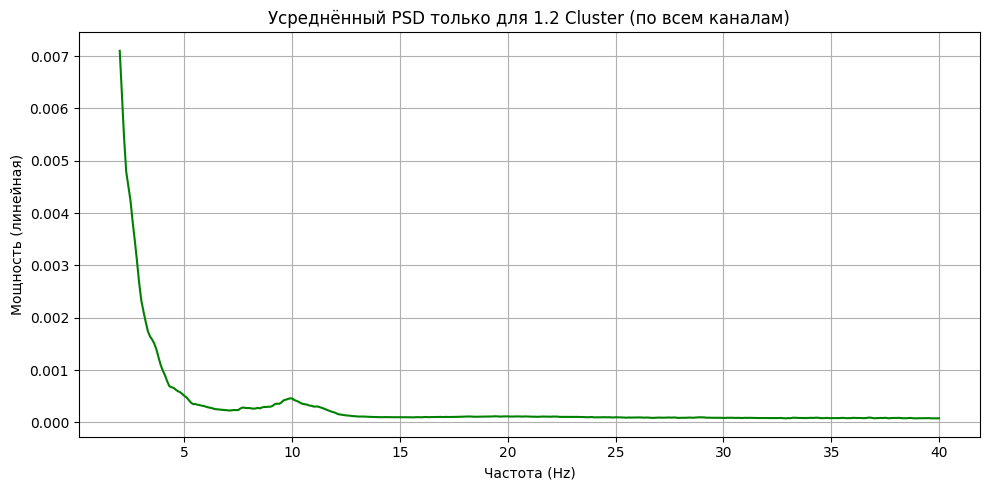

5 records.


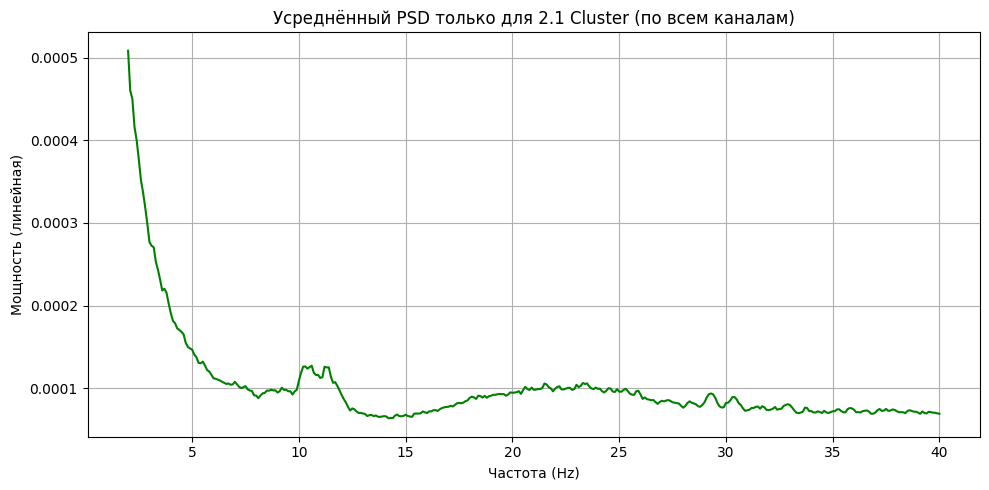

13 records.


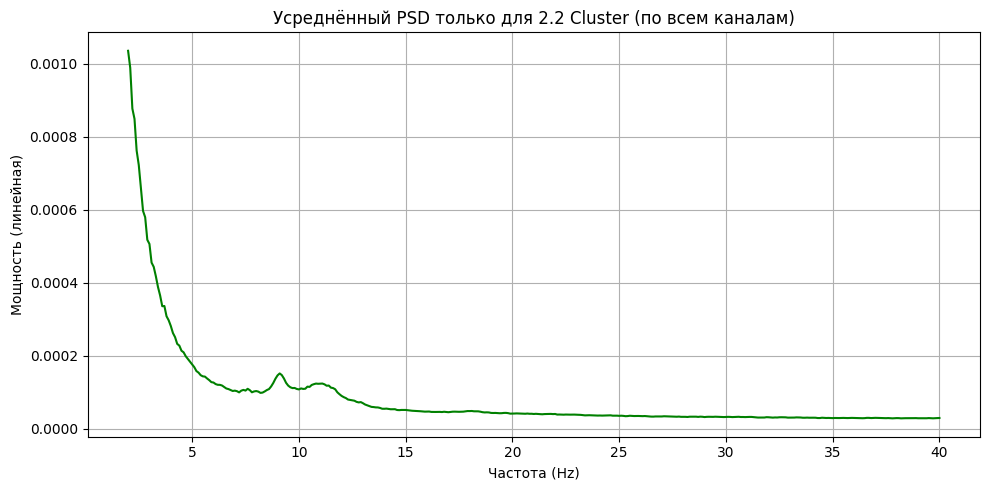

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Пример target_list
target_lists = [['S11_T2', 'S4_T2', 'S8_T1', 'S15_T2'], 
                
               ['S15_T1', 'S4_T1', 'S3_T2',
               'S10_T2', 'S1_T2', 'S8_T2', 'S6_T2', 'S1_T1', 'S6_T1'], 
                
               ['S7_T2', 'S7_T1', 'S9_T2', 'S9_T1', 'S14_T1'],
                
               ['S5_T2', 'S5_T1', 'S3_T1', 'S2_T2', 'S2_T1',
               'S10_T1', 'S12_T2', 'S12_T1', 'S16_T2', 'S16_T1',
               'S11_T1', 'S13_T2', 'S13_T1']]
clust_names = ['1.1', '1.2', '2.1', '2.2']

for target_list, clust_name in zip(target_lists, clust_names):
    # Сбор только целевых PSD
    target_psds = []
    
    for psd, s_id, t_id, *_ in results_arr:
        key = f"S{s_id}_T{t_id}"
        if key in target_list:
            target_psds.append(psd)
    
    # Проверка
    if not target_psds:
        raise ValueError("Ни один элемент из target_list не найден в results_arr.")
    print(f"{len(target_psds)} records.")
    
    # В массив и усреднение
    target_psds = np.array(target_psds)       # (n_target, 63, 381)
    # target_psds = 10 * np.log10(target_psds + 1e-12)
    mean_psd = target_psds.mean(axis=(0, 1))  # усреднение по людям и каналам → (381,)
    
    # Частотная ось
    freqs = np.linspace(2, 40, mean_psd.shape[0])
    
    # Визуализация
    plt.figure(figsize=(10, 5))
    plt.plot(freqs, mean_psd, color='green')
    plt.title(f"Усреднённый PSD только для {clust_name} Cluster (по всем каналам)")
    plt.xlabel("Частота (Hz)")
    plt.ylabel("Мощность (линейная)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


13 records.


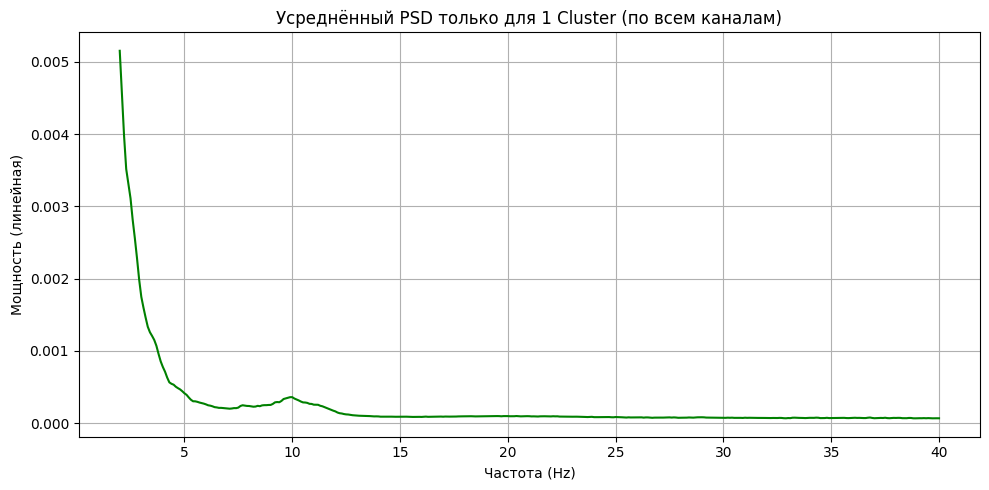

18 records.


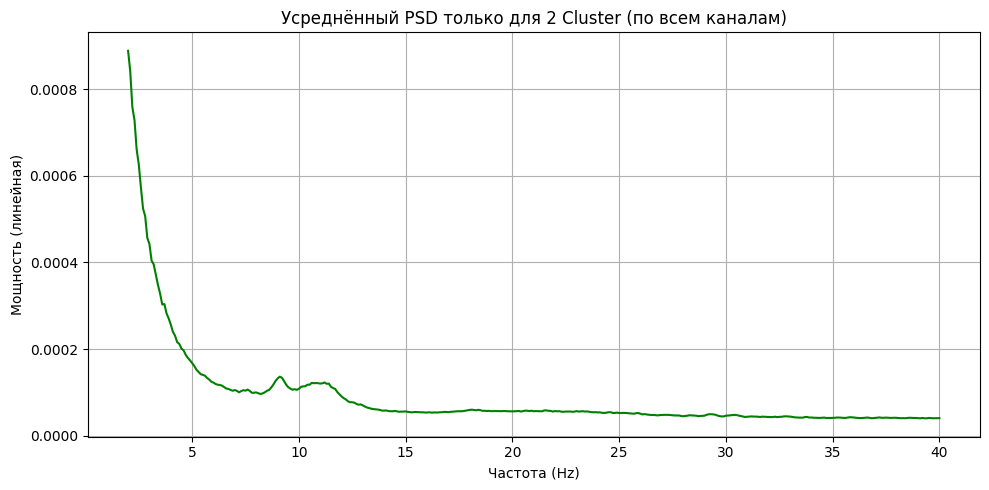

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Пример target_list
target_lists = [['S11_T2', 'S4_T2', 'S8_T1', 'S15_T2', 
               'S15_T1', 'S4_T1', 'S3_T2',
               'S10_T2', 'S1_T2', 'S8_T2', 'S6_T2', 'S1_T1', 'S6_T1'], 
                
               ['S7_T2', 'S7_T1', 'S9_T2', 'S9_T1', 'S14_T1',
                'S5_T2', 'S5_T1', 'S3_T1', 'S2_T2', 'S2_T1',
               'S10_T1', 'S12_T2', 'S12_T1', 'S16_T2', 'S16_T1',
               'S11_T1', 'S13_T2', 'S13_T1']]

clust_names = ['1', '2']

for target_list, clust_name in zip(target_lists, clust_names):
    # Сбор только целевых PSD
    target_psds = []
    
    for psd, s_id, t_id, *_ in results_arr:
        key = f"S{s_id}_T{t_id}"
        if key in target_list:
            target_psds.append(psd)
    
    # Проверка
    if not target_psds:
        raise ValueError("Ни один элемент из target_list не найден в results_arr.")
    print(f"{len(target_psds)} records.")
    
    # В массив и усреднение
    target_psds = np.array(target_psds)       # (n_target, 63, 381)
    # target_psds = 10 * np.log10(target_psds + 1e-12)
    mean_psd = target_psds.mean(axis=(0, 1))  # усреднение по людям и каналам → (381,)
    
    # Частотная ось
    freqs = np.linspace(2, 40, mean_psd.shape[0])
    
    # Визуализация
    plt.figure(figsize=(10, 5))
    plt.plot(freqs, mean_psd, color='green')
    plt.title(f"Усреднённый PSD только для {clust_name} Cluster (по всем каналам)")
    plt.xlabel("Частота (Hz)")
    plt.ylabel("Мощность (линейная)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()